In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Set up the paths for input data
BASE_PATH = os.path.abspath('.')
DATA_PATH = os.path.join(BASE_PATH, 'data')
data_file = str(input("Enter the file name of data: "))
DATA_FILE_PATH = os.path.join(DATA_PATH,data_file)


Enter the file name of data: example.txt


In [ ]:
content = []
x_data = []
y_data= []

with open(DATA_FILE_PATH, 'rt') as dataLines:
    for each in dataLines:
        pointsData = list(map(float,each.strip().split(' ')))
        x_data.append(pointsData[0])
        y_data.append(pointsData[1])
        content.append(tuple(pointsData))
        
print(content)
# print(x_data)
# print(y_data)

[(0.0, 0.0), (10.0, 125.0), (31.0, 577.0), (68.0, 1275.0), (98.0, 2551.0), (125.0, 4438.0), (155.0, 6921.0), (194.0, 9473.0), (239.0, 10456.0), (300.0, 12412.0), (330.0, 13594.0)]


In [ ]:
def euclidean_distance(d1, d2):
    n = len(d1)
    sum = 0
    for i in range(n):
        sum +=(d1[i]-d2[i])**2
    return sum**0.5

In [ ]:
def set_knots(param_list, degree):
    """sets the B-spline knots
    :param param_list:
    :param degree:
    :return:
    """
    t0 = [0.] * degree
#     print(t0)
    tn = [1.] * degree
#     print(tn)
    knots_list = t0 + param_list + tn
#     print(knots_list)
    return knots_list

In [ ]:
def evaluate(t, u, i, j):
    """evaluates the element of the N basis matrix
    :param t:
    :param u:
    :param i:
    :param j: 
    :return: N value
    """
    val = 0.

    if u[j] <= t[i] <= u[j + 1] and (t[i] != u[j] or t[i] != u[j + 1]):
        try:
            val = (t[i] - u[j]) ** 3 / ((u[j + 1] - u[j]) * (u[j + 2] - u[j]) * (u[j + 3] - u[j]))
        except ZeroDivisionError:
            val = 0.

    elif u[j + 1] <= t[i] < u[j + 2]:
        try:
            val = ((t[i] - u[j]) ** 2 * (u[j + 2] - t[i])) / (
                    (u[j + 2] - u[j + 1]) * (u[j + 3] - u[j]) * (u[j + 2] - u[j])) + \
                  ((u[j + 3] - t[i]) * (t[i] - u[j]) * (t[i] - u[j + 1])) / (
                    (u[j + 2] - u[j + 1]) * (u[j + 3] - u[j + 1]) * (u[j + 3] - u[j])) + \
                  ((u[j + 4] - t[i]) * ((t[i] - u[j + 1]) ** 2)) / (
                    (u[j + 2] - u[j + 1]) * (u[j + 4] - u[j + 1]) * (u[j + 3] - u[j + 1]))
        except ZeroDivisionError:
            val = 0.

    elif u[j + 2] <= t[i] < u[j + 3]:
        try:
            val = ((t[i] - u[j]) * (u[j + 3] - t[i]) ** 2) / (
                    (u[j + 3] - u[j + 2]) * (u[j + 3] - u[j + 1]) * (u[j + 3] - u[j])) + \
                  ((u[j + 4] - t[i]) * (u[j + 3] - t[i]) * (t[i] - u[j + 1])) / (
                    (u[j + 3] - u[j + 2]) * (u[j + 4] - u[j + 1]) * (u[j + 3] - u[j + 1])) + \
                  ((u[j + 4] - t[i]) ** 2 * (t[i] - u[j + 2])) / (
                    (u[j + 3] - u[j + 2]) * (u[j + 4] - u[j + 2]) * (u[j + 4] - u[j + 1]))
        except ZeroDivisionError:
            val = 0.

    elif u[j + 3] <= t[i] <= u[j + 4] and (t[i] != u[j + 3] or t[i] != u[j + 4]):
        try:
            val = (u[j + 4] - t[i]) ** 3 / (
                    (u[j + 4] - u[j + 3]) * (u[j + 4] - u[j + 2]) * (u[j + 4] - u[j + 1]))
        except ZeroDivisionError:
            val = 0.

    return val

In [ ]:
def endpoints(t, u, i, j):
    """endpoints conditions
    :param t:
    :param u:
    :param i:
    :param j:
    :return:
    """
    val_ = 0.

    if u[j] <= t[i] <= u[j + 1] and (t[i] != u[j] or t[i] != u[j + 1]):
        try:
            val_ = 6 * (t[i] - u[j]) / ((u[j + 1] - u[j]) * (u[j + 2] - u[j]) * (u[j + 3] - u[j]))
        except ZeroDivisionError:
            val_ = 0.

    elif u[j + 1] <= t[i] <= u[j + 2] and (t[i] != u[j + 1] or t[i] != u[j + 2]):
        try:
            val_ = (2 * (u[j + 2] - t[i]) - 4 * (t[i] - u[j])) / (
                    (u[j + 2] - u[j + 1]) * (u[j + 3] - u[j]) * (u[j + 2] - u[j])) + \
                   (2 * u[j] - 6 * t[i] + 2 * u[j + 1] + 2 * u[j + 3]) / (
                    (u[j + 2] - u[j + 1]) * (u[j + 3] - u[j + 1]) * (u[j + 3] - u[j])) + \
                   (4 * u[j + 1] - 6 * t[i] + 2 * u[j + 4]) / (
                    (u[j + 2] - u[j + 1]) * (u[j + 4] - u[j + 1]) * (u[j + 3] - u[j + 1]))
        except ZeroDivisionError:
            val_ = 0.

    elif u[j + 2] <= t[i] <= u[j + 3] and (t[i] != u[j + 2] or t[i] != u[j + 3]):
        try:
            val_ = (6 * t[i] - 2 * u[j] - 4 * u[j + 3]) / (
                    (u[j + 3] - u[j + 2]) * (u[j + 3] - u[j + 1]) * (u[j + 3] - u[j])) + \
                   (6 * t[i] - 2 * u[j + 1] - 2 * u[j + 3] - 2 * u[j + 4]) / (
                    (u[j + 3] - u[j + 2]) * (u[j + 4] - u[j + 1]) * (u[j + 3] - u[j + 1])) + \
                   (6 * t[i] - 2 * u[j + 2] - 4 * u[j + 4]) / (
                    (u[j + 3] - u[j + 2]) * (u[j + 4] - u[j + 2]) * (u[j + 4] - u[j + 1]))
        except ZeroDivisionError:
            val_ = 0.

    elif u[j + 3] <= t[i] <= u[j + 4] and (t[i] != u[j + 3] or t[i] != u[j + 4]):
        try:
            val_ = 6 * (u[j + 4] - t[i]) / (
                    (u[j + 4] - u[j + 3]) * (u[j + 4] - u[j + 2]) * (u[j + 4] - u[j + 1]))
        except ZeroDivisionError:
            val_ = 0.

    return val_

In [ ]:
def zeros_matrix(rows, cols):
    M = []
    while len(M) < rows:
        M.append([])
        while len(M[-1]) < cols:
            M[-1].append(0.0)

    return M

In [ ]:
def basis(params_list, knots_list):
    """Cubic B-spline basis
    :param params_list:
    :param knots_list:
    :return: basis matrix
    """
    n = len(params_list) - 1
    cnt_num = n + 3  # control points
    basis_mat = zeros_matrix(cnt_num, cnt_num)
#     print(basis_mat)
#     print("-------")

    for i in range(n + 1):
        for j in range(n + 3):
            basis_mat[i + 1][j] = evaluate(params_list, knots_list, i, j)
#     print(basis_mat)
#     print("-------")
    for i in range(2):
        for j in range(n + 3):
            basis_mat[i * (n + 2)][j] = endpoints(params_list, knots_list, i * n, j)
#     print(basis_mat)
#     print(basis_mat)
    return basis_mat

In [ ]:
type_ = 'chord'
n = len(content)
# print(n)
# print(content)
t = [0.] * n
# print(t)
# print(len(t))
# print([0.0, 0.08595808541823045, 0.1991936114627612, 0.30543744532009176, 0.3898853092121142, 0.4999999993548314, 0.6101146884126033, 0.6945625525897042, 0.800806387473565, 0.9140419140810072, 1.0])
if type_ == 'chord':
    denominator = 0
    for k in range(1, n):
        denominator += euclidean_distance(content[k], content[k - 1])
    for i in range(1, n):
        numerator = 0
        for k in range(1, i + 1):
            numerator += euclidean_distance(content[k], content[k - 1])
        t[i] = numerator / denominator
elif type_ == 'uniform':
    for i in range(1, n):
        t[i] = i / n

else:
    msg = "Parameterization method doesn't exist"
    raise LookupError(msg)
# print(t)
t[-1] = 1
print(t)
# print(len(t))
k = set_knots(t, 3)
# print(t)
print(k)

basis_mat = basis(t,k)

# print(basis_mat)

[0.0, 0.009221047842095306, 0.042494020310348525, 0.0938924297547158, 0.18774704227214803, 0.3265188675510278, 0.5091157525025775, 0.6967950312204402, 0.7691541141015229, 0.9130554704741942, 1]
[0.0, 0.0, 0.0, 0.0, 0.009221047842095306, 0.042494020310348525, 0.0938924297547158, 0.18774704227214803, 0.3265188675510278, 0.5091157525025775, 0.6967950312204402, 0.7691541141015229, 0.9130554704741942, 1, 1.0, 1.0, 1.0]


In [ ]:
def tridiag_solver(a, b, c, d):
    """ Tri-diagonal matrix solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9
    :param a: lower diagonal
    :param b: main diagonal
    :param c: upper diagnoal
    :param d: right hand side of the system
    :return: solution of the system
    """
    nf = len(d)
    ac, bc, cc, dc = map(list, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]

    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]
#     print((xc))
    return xc


In [ ]:
control_points = []
n = len(basis_mat[0])
d0 = [(0,0)]
appended_data_points = d0 + content + d0
x = [each[0] for each in appended_data_points]
# print(x)
y = [each[1] for each in appended_data_points]
# print(y)
basis_mat[0] , basis_mat[1] = basis_mat[1], basis_mat[0]
basis_mat[n-2], basis_mat[n-1] = basis_mat[n-1], basis_mat[n-2]
x[0], x[1] = x[1], x[0]
x[n - 2], x[n - 1] = x[n - 1], x[n - 2]
y[0], y[1] = y[1], y[0]
y[n - 2], y[n - 1] = y[n - 1], y[n - 2]

lower_diag = [basis_mat[i + 1][i] for i in range(n - 1)]
main_diag = [basis_mat[i][i] for i in range(n)]
upper_diag = [basis_mat[i][i + 1] for i in range(n - 1)]

x_control = tridiag_solver(lower_diag, main_diag, upper_diag, x)
y_control = tridiag_solver(lower_diag, main_diag, upper_diag, y)

for i in range(n):
    control_points.append((x_control[i], y_control[i]))


In [ ]:
def B(x, k, i, t):
    """recursive definition of B-Spline curve
    :param x:
    :param k:
    :param i:
    :param t:
    :return:
    """
    if k == 0:
        return 1.0 if t[i] <= x < t[i + 1] else 0.0
    if t[i + k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i]) / (t[i + k] - t[i]) * B(x, k - 1, i, t)
    if t[i + k + 1] == t[i + 1]:
        c2 = 0.0
    else:
        c2 = (t[i + k + 1] - x) / (t[i + k + 1] - t[i + 1]) * B(x, k - 1, i + 1, t)
    return c1 + c2

In [ ]:
def bspline(x, t, c, k):
    """evaluate B-Spline curve
    :param x:
    :param t:
    :param c:
    :param k:
    :return:
    """
    n = len(t) - k - 1
    assert (n >= k + 1) and (len(c) >= n)
    return sum(c[i] * B(x, k, i, t) for i in range(n))

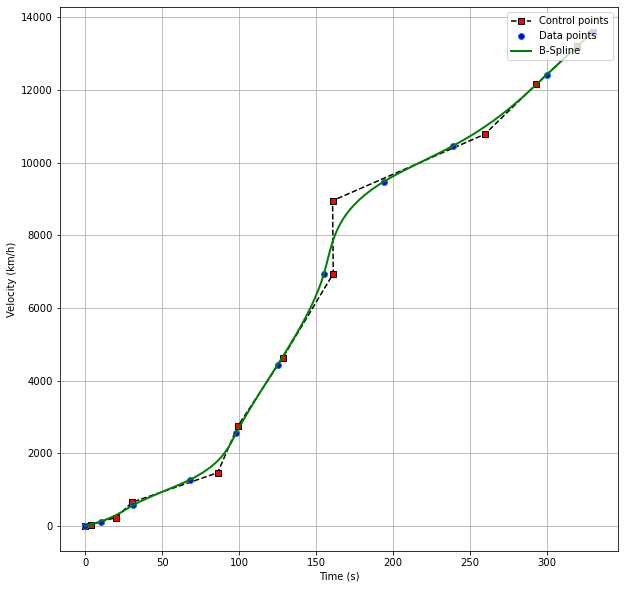

In [ ]:
data_points, data_points_x, data_points_y = content, x_data, y_data
degree, cnt_num, knots_list, control_points_x, control_points_y = 3, len(control_points), k, x_control, y_control
# print(knots_list)
xx = [x/100 for x in list(range(100))]
# print(xx)
# Define the x-axis label
x_label = 'Time (s)'
# Define the y-axis label
y_label = 'Velocity (km/h)'
fig, ax = plt.subplots(figsize=(10,10))
x = [bspline(x, knots_list, control_points_x, degree) for x in xx]
y = [bspline(x, knots_list, control_points_y, degree) for x in xx]

ax.plot(control_points_x, control_points_y, 'k--', marker='s', markerfacecolor='r', label='Control points')
ax.plot(data_points_x, data_points_y,' ', marker='o', markerfacecolor='b', label='Data points')
ax.plot(x, y, 'g-', lw=2, label='B-Spline')
# Set the x-axis label
ax.set_xlabel(x_label)
# Set the y-axis label
ax.set_ylabel(y_label)
ax.grid(True)
ax.legend(loc='upper right')
plt.show()